In [40]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import math
import pandas as pd
import os.path, os, sys, glob, json, pathlib
import jinja2
from multiprocessing import Pool
from jinja2 import Template
from itertools import product
import ruamel_yaml as yaml
from io import StringIO 
from scipy import stats
import re
from scipy.interpolate import griddata
import matplotlib.cm as cm
from scipy import ndimage


#plt.style.use('white_background')
plt.rcParams.update({'font.size': 18, 'figure.figsize': [10.0, 8]})
# Set default color for all text elements to black
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.titlecolor'] = 'black'

# change this to the directory where you want to run the simulations    
#workdir = '/home/isabel/Documents/CPPM-master/cppm-crowded-main/mixed' # change this!!
plot_dir = '/home/isabel/Documents/CPPM-master/rust/duello/examples/cppm/log' # change this!!

In [82]:
def get_B2(temperatures, molality):
    b2 = np.zeros((len(temperatures), len(molality)))
    redb2 = np.zeros((len(temperatures), len(molality)))
    #temperatures = np.arange(273, 313, 1)
    for  Tidx, T in enumerate(temperatures):
        b2vals = []
        redb2vals = []
        for Midx, M in enumerate(molality):
            
            M =('{:.15f}'.format(M)).rstrip('0').rstrip('.')
            #print(T, M)
            file = f"log_{T}_{M}.log"
            with open(file, 'r') as f:
                lines = f.readlines()
                L1 = lines[7].split()
                L2 = lines[9].split()
                #b2vals.append(float(L1[8]))
                #redb2vals.append(float(L2[11]))
                #print(float(L1[8]))
                f.close()
                b2[Tidx, Midx] = float(L1[8])
                
                redb2[Tidx, Midx] = float(L2[11])
    mat = np.matrix(redb2)
    with open('valuesB2.txt','wb') as f:
        for line in mat:
            np.savetxt(f, line, fmt='%.2f')   #print(b2)
    return b2, redb2

def normalize_z_score(matrix):
    mean_val = np.mean(matrix)
    std_val = np.std(matrix)
    return (matrix - mean_val) / std_val

def plot_B2(temperatures, molality, b2, savepath=None):
     # Create a figure with a white background
    fig, ax = plt.subplots(facecolor='white')
    ax.set_facecolor('white')
    #b2 = normalize_z_score(b2)
    # Create masks for positive and negative values
    positive_mask = np.ma.masked_less_equal(b2, 0)
    negative_mask = np.ma.masked_greater(b2, 0)
    # Create a custom colormap
    cmap = plt.cm.viridis
    cmap.set_bad(color='white')  # Set color for masked values
    
    Cbar = ax.imshow(b2, aspect='auto', origin='lower', 
               extent=[temperatures[0], temperatures[-1], molality[0], molality[-1]], alpha = 1)
    #Cbar2 = ax.imshow(negative_mask, aspect='auto', origin='lower', 
    #           extent=[temperatures[0], temperatures[-1], molality[0], molality[-1]], alpha = 0.8)
    norm = cm.colors.Normalize(vmin=np.min(b2), vmax=np.max(b2))
    #fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label=f'$B_2 (Å³)$')
    fig.colorbar(Cbar , label=f'$B_2/B_2HS$' )# (Å³)$')
    ax.set_ylabel('Molality (M)')
    ax.set_xlabel('Temperature (K)')
    ax.set_title(f'$B_2/B_2HS$ for two $P^1_8$ particles')
    
     # Adding contour where B2 is equal to zero
    T, M = np.meshgrid(temperatures, molality, indexing='ij')
    points = np.array([T.flatten(), M.flatten()]).T
    values = b2.flatten()
  
    #print(points , values)
    # Create a grid for interpolation
    grid_x, grid_y = np.mgrid[temperatures[0]:temperatures[-1]:50j, molality[0]:molality[-1]:50j]
    grid_z = griddata(points, values, (grid_x, grid_y), method='cubic')
    out= ndimage.zoom(b2.T, zoom = 4, order = 4)
    zoomT = np.linspace(temperatures[0], temperatures[-1], out.shape[0]).T
    zoomM = np.linspace(molality[0], molality[-1], out.shape[1]).T
    zoomT, zoomM = np.meshgrid(zoomT, zoomM, indexing='ij')
    contour = ax.contour(zoomT, zoomM, out, levels=[-20, -10,-5, -1, 10], colors= ['black', 'white', '#7f3db3', '#0000dc','red']) #['black', 'white', 'cyan', 'magenta'])
    print(out)
    # Round the interpolated values to the nearest integer
    grid_z = np.round(grid_z).astype(int)
    tol = 9.5*10**-6
    zeros = np.where(abs(grid_z.T) < 1)
    #zeros = np.where(abs(grid_z) < tol)
    #print(zeros, grid_z)
    # Plot the contour line where grid_z is equal to zero
    #contour = ax.contour(grid_x, grid_y, grid_z.T, levels=[-20, -10,-5, -1, 10], colors= ['black', 'white', '#7f3db3', '#0000dc','red']) #['black', 'white', 'cyan', 'magenta'])
    #ax.plot(grid_x[zeros], grid_y[zeros], 'ro', markersize=0.5)
    #T, M = np.meshgrid(temperatures, molality, indexing='ij')
    #contour = ax.contour(T, M, grid_z.T, levels=[-10, -5, 5, 10], colors='black', linestyles='dashed')
    manual_locations = [(310, 0.02), (282,0.04), (300, 0.06),(295, 0.08), (285,0.0075)]
    ax.clabel(contour, inline=True, fontsize=15, manual = manual_locations)
    # Print the contour paths
    #for collection in contour.collections:
    #    for path in collection.get_paths():
    #        print("Contour path coordinates:")
    #        print(path.vertices)
    if savepath:
        plt.savefig(savepath, bbox_inches='tight', facecolor='white')
    
    plt.show()
    

/home/isabel/Documents/CPPM-master/rust/duello/examples/cppm/log
/home/isabel/Documents/CPPM-master/rust/duello/examples/cppm/log
[[23.47       23.11066183 22.11251515 ...  0.92433706  0.92853196
   0.93      ]
 [23.47363694 23.11425987 22.11598888 ...  0.92401448  0.92861177
   0.9302374 ]
 [23.48294542 23.12345463 22.1248256  ...  0.92308456  0.92870736
   0.93073526]
 ...
 [20.78586238 20.27903843 18.86661911 ...  0.78057562  0.78767115
   0.79025671]
 [20.76691348 20.25927118 18.84449383 ...  0.78043782  0.78750949
   0.79008378]
 [20.76       20.25206446 18.83644042 ...  0.78036744  0.78742999
   0.79      ]]


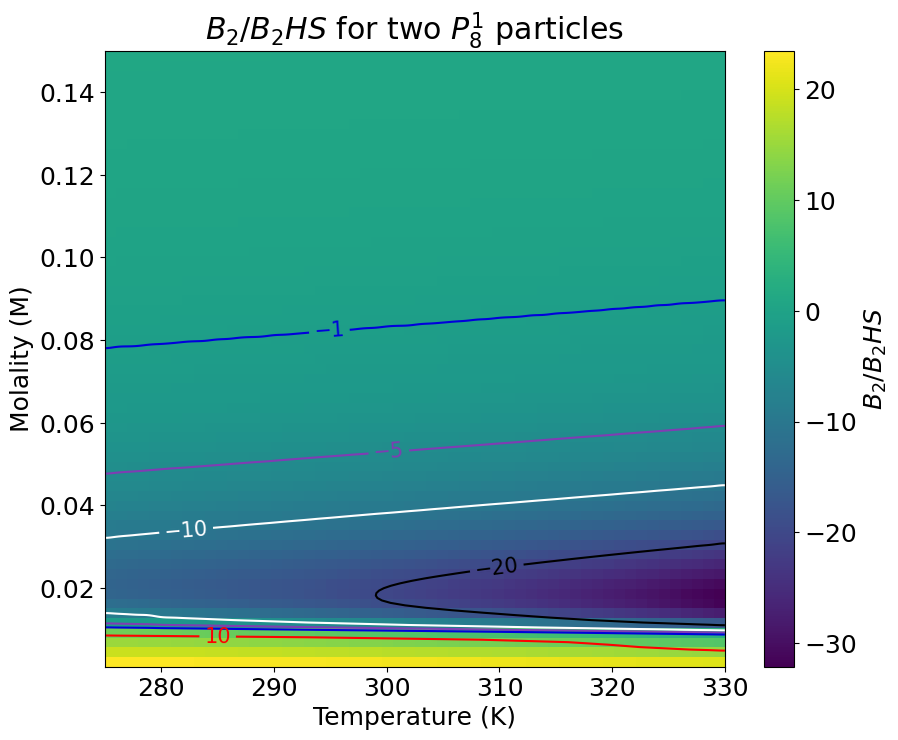

In [83]:
%cd $plot_dir
!pwd
mol = np.linspace(0.0025, 0.15 , 60)
mol = np.insert(mol, [0], [0.001, 0.0015, 0.002])
temp= np.arange(275,331,1)
B2, rB2 = get_B2(temp, mol)

plot_B2(temp, mol, rB2.T, '../smooth_redB2.pdf')

In [34]:
grid_z

array([[[-5.        , -4.65517241, -4.31034483, ...,  4.31034483,
          4.65517241,  5.        ],
        [-5.        , -4.65517241, -4.31034483, ...,  4.31034483,
          4.65517241,  5.        ],
        [-5.        , -4.65517241, -4.31034483, ...,  4.31034483,
          4.65517241,  5.        ],
        ...,
        [-5.        , -4.65517241, -4.31034483, ...,  4.31034483,
          4.65517241,  5.        ],
        [-5.        , -4.65517241, -4.31034483, ...,  4.31034483,
          4.65517241,  5.        ],
        [-5.        , -4.65517241, -4.31034483, ...,  4.31034483,
          4.65517241,  5.        ]],

       [[-5.        , -4.65517241, -4.31034483, ...,  4.31034483,
          4.65517241,  5.        ],
        [-5.        , -4.65517241, -4.31034483, ...,  4.31034483,
          4.65517241,  5.        ],
        [-5.        , -4.65517241, -4.31034483, ...,  4.31034483,
          4.65517241,  5.        ],
        ...,
        [-5.        , -4.65517241, -4.31034483, ...,  